In [1]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os

# Modules
from KG_test import gpt_test, gpt_test_loss, pinn_test, pinn_test_loss
from KG_precompute import inputs, gram_schmidt1, gram_schmidt2
from KG_train import pinn_train, offline_generation
from KG_data import residual_data, ICBC_data
from KG_precompute import xcos_term
from KG_models import NN

data_dir = "./kg_data"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

device = torch.device("cpu")
print_seperator = 60*"*"


In [2]:
params = np.load(data_dir+"/params_gpt_bic_adam.npy", allow_pickle=True).item()

xi, xf, ti, tf = params["domain"]["xi"], params["domain"]["xf"], params["domain"]["ti"], params["domain"]["tf"]
Nc = params["data sizes"]["Nc"]
N_test = params["data sizes"]["N_test"]
BC_pts = params["data sizes"]["BC_pts"]
IC_pts = params["data sizes"]["IC_pts"]
layers_pinn = params["layers pinn"]
lr_pinn = params["lr pinn"]
epochs_pinn = params["epochs pinn"]
parameter_size = params["parameter size"]
number_of_neurons = params["number of neurons"]
lr_gpt = params[f"lr gpt"]
epochs_gpt_train = params[f"epochs gpt train"]
test_cases = params["test cases"]
epochs_gpt_test = params[f"epochs gpt test"]
sparse = params["sparse"]
seed = params["seed"]

In [3]:
variables = torch.load(data_dir+"/variables_gpt_bic_adam.npy", map_location=torch.device('cpu'))

kg_test = variables["kg_test"]
c_initial = variables["c_initial"]
xt_len = variables["xt_len"]
IC_size = variables["IC_size"]
BC_size = variables["BC_size"]
IC_u1 = variables["IC_u1"]
IC_u2 = variables["IC_u2"]
BC_u = variables["BC_u"]
train_xcos = variables["train_xcos"]
train_out = variables["train_out"]
train_out_xx = variables["train_out_xx"]
train_out_tt = variables["train_out_tt"]
train_out_IC = variables["train_out_IC"]
train_out_IC_t = variables["train_out_IC_t"]
train_out_BC = variables["train_out_BC"]
fhat = variables["fhat"]
epochs_gpt_train = variables["epochs_gpt_train"]
lr_gpt = variables["lr_gpt"]
out_test = variables["out_test"]

In [4]:
kg_test = np.loadtxt(data_dir + "/kg_test.dat")
pinn_test_soln = np.loadtxt(data_dir+"/test_pinn_soln.dat")

from KG_test import gpt_test_bic,gpt_test_loss_bic
print(f"GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,out_test,None)

test_gpt_losses = gpt_test_loss_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,None)
print(f"GPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended



In [11]:
variables_sgpt = torch.load(data_dir+"/variables_sgpt_bic_adam.npy", map_location=torch.device('cpu'))

kg_test = variables_sgpt["kg_test"]
c_initial = variables_sgpt["c_initial"]
xt_len = variables_sgpt["xt_len"]
IC_size = variables_sgpt["IC_size"]
BC_size = variables_sgpt["BC_size"]
IC_u1 = variables_sgpt["IC_u1"]
IC_u2 = variables_sgpt["IC_u2"]
BC_u = variables_sgpt["BC_u"]
train_xcos = variables_sgpt["train_xcos"]
train_out = variables_sgpt["train_out"]
train_out_xx = variables_sgpt["train_out_xx"]
train_out_tt = variables_sgpt["train_out_tt"]
train_out_IC = variables_sgpt["train_out_IC"]
train_out_IC_t = variables_sgpt["train_out_IC_t"]
train_out_BC = variables_sgpt["train_out_BC"]
fhat = variables_sgpt["fhat"]
epochs_gpt_train = variables_sgpt["epochs_gpt_train"]
lr_gpt = variables_sgpt["lr_gpt"]
out_test = variables_sgpt["out_test"]
Lhat = variables_sgpt["Lhat"]

In [12]:
from KG_test import gpt_test_bic,gpt_test_loss_bic
print(f"SGPT-PINN Testing Started")
test_sgpt_time, test_sgpt_soln = gpt_test_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,out_test,Lhat)

test_sgpt_losses = gpt_test_loss_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,Lhat)
print(f"SGPT-PINN Testing Ended\n")

SGPT-PINN Testing Started
SGPT-PINN Testing Ended



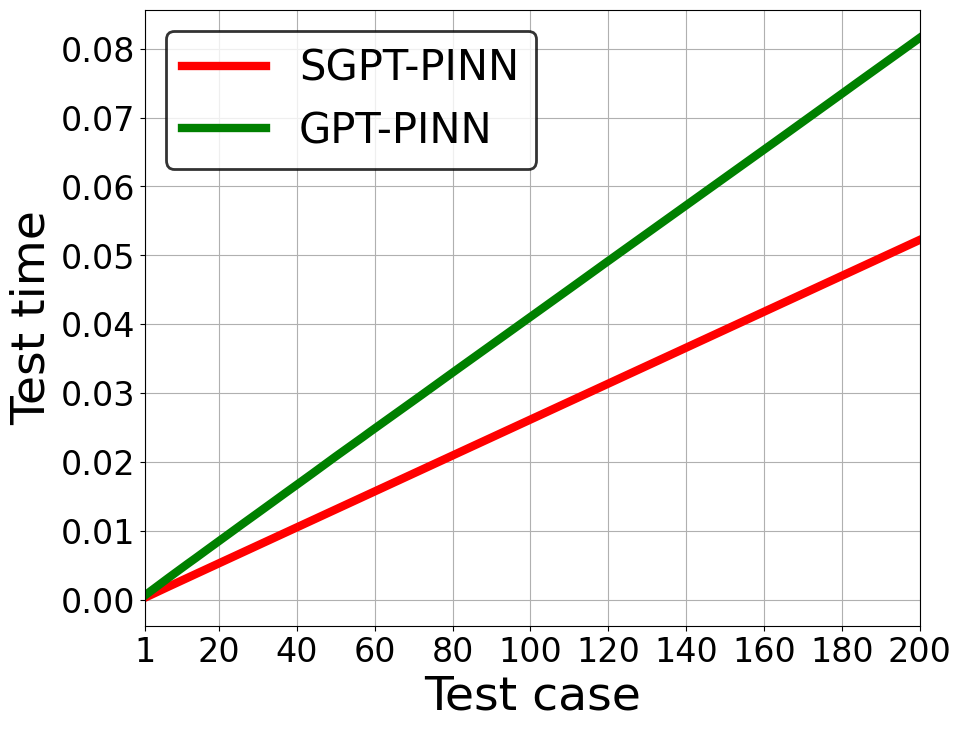

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
x_plt16 = range(1,test_sgpt_time.shape[0]+1) 
x_ticks = list(range(0,test_sgpt_time.shape[0]+1,20))
x_ticks[0] = 1
ax.plot(x_plt16, test_sgpt_time, color="red",   label="SGPT-PINN", lw=6)
ax.plot(x_plt16, test_gpt_time,  color="green", label="GPT-PINN",  lw=6)
ax.set_xticks(ticks=x_ticks)
ax.set_xlim(min(x_plt16),max(x_plt16))
ax.set_xlabel("Test case", fontsize=34)
ax.set_ylabel("Test time", fontsize=34)
legend = ax.legend(frameon=True, fontsize=30)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=24)
ax.grid()
#plt.yscale('log')
plt.show()

In [14]:
np.savetxt(data_dir+f"/test_gpt_losses.dat", test_gpt_losses)
np.savetxt(data_dir+f"/test_gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_gpt_time.dat",   test_gpt_time)

np.savetxt(data_dir+f"/test_bic_sgpt_losses.dat", test_sgpt_losses)
np.savetxt(data_dir+f"/test_bic_sgpt_soln.dat",   test_sgpt_soln)
np.savetxt(data_dir+f"/test_bic_sgpt_time.dat",   test_sgpt_time)